# **Load The files**


In [13]:
# Peru School Dropout: Urban vs. Rural Deep Dive
#
# Objective: This script performs an exploratory data analysis (EDA) on the
# Peruvian school dropout dataset. The primary goal is to leverage the
# ubigeo_ccpp.csv file to accurately classify educational districts as either
# 'Urban' or 'Rural' and uncover deeper insights into the disparities between
# these areas.

# ## 1. Setup and Data Loading
# First, we'll import the necessary libraries and load the three CSV files.
# The script assumes the CSV files are in the same directory as this script.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import KMeans
import seaborn as sns
import io

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the datasets from the local directory
try:
    df_primary = pd.read_csv('Educacion_Primaria.csv')
    df_secondary = pd.read_csv('Educacion_Secundaria.csv')
    df_geo = pd.read_csv('ubigeo_ccpp.csv')
    print("\nFiles loaded successfully into dataframes!")
except FileNotFoundError as e:
    print(f"\nError: {e}. Please ensure all three required CSV files ('Educacion_Primaria.csv', 'Educacion_Secundaria.csv', 'ubigeo_ccpp.csv') are in the same directory as this script.")
    exit()

output_dir = Path("/content/")
output_dir.mkdir(parents=True, exist_ok=True)


Files loaded successfully into dataframes!


# **Clean the Data**

In [14]:
# Before analysis, we need to clean and standardize the data. This involves:
# 1.  Stripping whitespace from column names.
# 2.  Ensuring the `ubigeo` identifier is a standardized 6-digit string format across all dataframes.
# 3.  Converting relevant columns to numeric types for calculations.

def clean_data(df, is_geo=False):
    """Cleans and standardizes the education and geo dataframes."""
    df.columns = df.columns.str.strip()

    if is_geo:
        # For the geo file, we use 'inei_distrito' as the key
        df.rename(columns={'inei_distrito': 'ubigeo'}, inplace=True)
        df['ubigeo'] = df['ubigeo'].astype(str).str.zfill(6)
    else:
        # For education files
        df['ubigeo'] = df['ubigeo'].astype(str).str.zfill(6)
        numeric_cols = ['desertor', 'denominador', 'Tasa']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        df.rename(columns={'Tasa': 'tasa'}, inplace=True)
    return df

# Clean all dataframes
df_primary = clean_data(df_primary)
df_secondary = clean_data(df_secondary)
df_geo = clean_data(df_geo, is_geo=True)

print("\nDataframes cleaned and prepared.")




Dataframes cleaned and prepared.


# **Show the Information of Data**


In [15]:
df_primary.info()
print("\n")
df_secondary.info()
print("\n")
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ubigeo        1890 non-null   object 
 1   Departamento  1890 non-null   object 
 2   Provincia     1890 non-null   object 
 3   Distrito      1890 non-null   object 
 4   desertor      1890 non-null   int64  
 5   denominador   1890 non-null   int64  
 6   tasa          1890 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 103.5+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1846 entries, 0 to 1845
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ubigeo        1846 non-null   object 
 1   Departamento  1846 non-null   object 
 2   Provincia     1846 non-null   object 
 3   Distrito      1846 non-null   object 
 4   desertor      1846 non-null   int64  
 5   denominador   1846 non-null  

In [16]:
print("\nPrimary Data Info:\n")
df_primary



Primary Data Info:



,ubigeo,Departamento,Provincia,Distrito,desertor,denominador,tasa
0,010101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,17,4146,0.410034
1,010102,AMAZONAS,CHACHAPOYAS,ASUNCION,0,12,0.000000
2,010103,AMAZONAS,CHACHAPOYAS,BALSAS,0,168,0.000000
3,010104,AMAZONAS,CHACHAPOYAS,CHETO,0,44,0.000000
4,010105,AMAZONAS,CHACHAPOYAS,CHILIQUIN,3,62,4.838710
...,...,...,...,...,...,...,...
1885,250304,UCAYALI,PADRE ABAD,NESHUYA,37,2114,1.750237
1886,250305,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,9,911,0.987925
1887,250306,UCAYALI,PADRE ABAD,HUIPOCA,11,627,1.754386
1888,250307,UCAYALI,PADRE ABAD,BOQUERON,9,674,1.335312


In [17]:
print("\nSecondary Data Info:\n")
df_secondary


Secondary Data Info:



,ubigeo,Departamento,Provincia,Distrito,desertor,denominador,tasa
0,010101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,42,3421,1.227711
1,010103,AMAZONAS,CHACHAPOYAS,BALSAS,5,125,4.000000
2,010104,AMAZONAS,CHACHAPOYAS,CHETO,0,54,0.000000
3,010106,AMAZONAS,CHACHAPOYAS,CHUQUIBAMBA,7,171,4.093567
4,010107,AMAZONAS,CHACHAPOYAS,GRANADA,0,62,0.000000
...,...,...,...,...,...,...,...
1841,250304,UCAYALI,PADRE ABAD,NESHUYA,11,1507,0.729927
1842,250305,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,32,619,5.169628
1843,250306,UCAYALI,PADRE ABAD,HUIPOCA,0,300,0.000000
1844,250307,UCAYALI,PADRE ABAD,BOQUERON,10,568,1.760563


In [18]:
print("\nGeo Data Info:\n")
df_geo


Geo Data Info:



,inei_ccpp,ubigeo,departamento,provincia,distrito,ccpp,tipo,latitude,longitude
0,101010001,010101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,CHACHAPOYAS,Urban,-6.229554,-77.872806
1,101010002,010101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,CACLIC,Rural,-6.200755,-77.901933
2,101010003,010101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,VITALIANO,Rural,-6.209867,-77.872655
3,101010004,010101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,EL TAPIAL,Rural,-6.208263,-77.867562
4,101010007,010101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,BOCANEGRA,Rural,-6.225491,-77.886864
...,...,...,...,...,...,...,...,...,...
94917,2504010056,250401,UCAYALI,PURUS,PURUS,PUERTO BETEL,Rural,-9.996660,-71.064303
94918,2504010059,250401,UCAYALI,PURUS,PURUS,NUEVO JORDAN,Rural,-9.848912,-70.858975
94919,2504010060,250401,UCAYALI,PURUS,PURUS,PERUANITA,Rural,-9.874705,-70.886167
94920,2504010061,250401,UCAYALI,PURUS,PURUS,SAN RAMON,Rural,-10.129015,-71.013428


In [19]:
# This is the key step. We will use `df_geo` to classify each district (`ubigeo`) as 'Urban' or 'Rural'.
#
# Methodology: A district can contain multiple populated centers (`ccpp`), some urban and some rural.
# We will classify a district as 'Urban' if it contains at least one populated center designated as 'Urban'.
# If all populated centers within a district are 'Rural', we will classify the entire district as 'Rural'.
# This approach assumes that the presence of an urban center significantly influences the district's overall
# character and infrastructure.

# Find all unique districts that contain at least one 'Urban' center
urban_districts = df_geo[df_geo['tipo'] == 'Urban']['ubigeo'].unique()

def classify_district(ubigeo):
    return 'Urban' if ubigeo in urban_districts else 'Rural'

# Apply the classification to our education dataframes
df_primary['location_type'] = df_primary['ubigeo'].apply(classify_district)
df_secondary['location_type'] = df_secondary['ubigeo'].apply(classify_district)

print("\nDistrict classification complete.")
print("\nPrimary Data Location Distribution:")
print(df_primary['location_type'].value_counts())
print("\nSecondary Data Location Distribution:")
print(df_secondary['location_type'].value_counts())


District classification complete.

Primary Data Location Distribution:
location_type
Urban    1874
Rural      16
Name: count, dtype: int64

Secondary Data Location Distribution:
location_type
Urban    1830
Rural      16
Name: count, dtype: int64


# **Aggregating Data by Location**


--- Primary School Dropout Analysis ---
  location_type  total_desertores  total_enrolled  dropout_rate
0         Rural                73            7387      0.988223
1         Urban             64390         3714465      1.733493

--- Secondary School Dropout Analysis ---
  location_type  total_desertores  total_enrolled  dropout_rate
0         Rural               115            5275      2.180095
1         Urban             72167         2837556      2.543280

Plot for Urban vs. Rural Dropout Rates


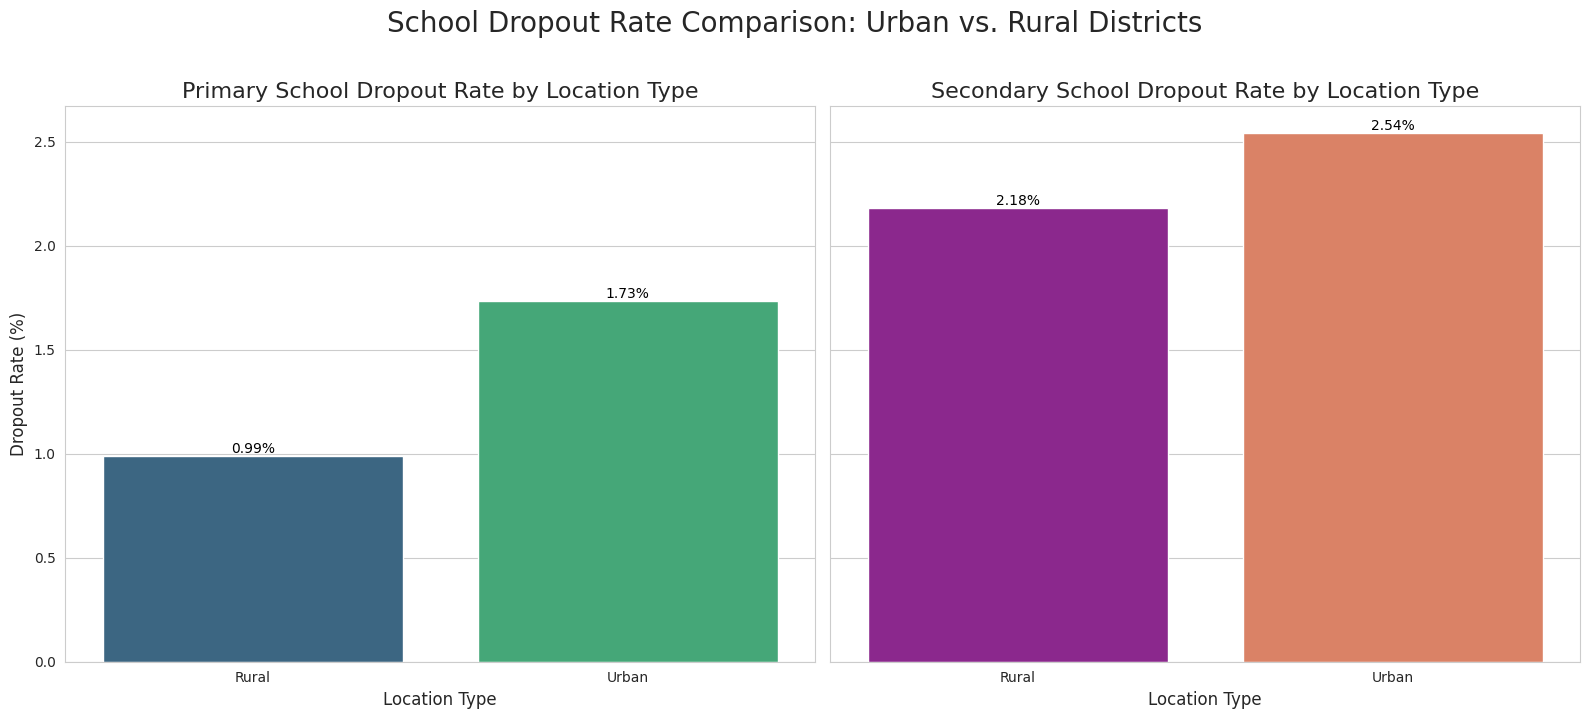

In [20]:
# Now that we have a reliable `location_type` for each district, we can analyze the dropout rates.

# Aggregate data by the new location t
primary_agg = df_primary.groupby('location_type').agg(
    total_desertores=('desertor', 'sum'),
    total_enrolled=('denominador', 'sum')
).reset_index()
primary_agg['dropout_rate'] = (primary_agg['total_desertores'] / primary_agg['total_enrolled']) * 100

secondary_agg = df_secondary.groupby('location_type').agg(
    total_desertores=('desertor', 'sum'),
    total_enrolled=('denominador', 'sum')
).reset_index()
secondary_agg['dropout_rate'] = (secondary_agg['total_desertores'] / secondary_agg['total_enrolled']) * 100

print("\n--- Primary School Dropout Analysis ---")
print(primary_agg)

print("\n--- Secondary School Dropout Analysis ---")
print(secondary_agg)

# ### Visualization: Urban vs. Rural Dropout Rates
fig, ax = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

sns.barplot(data=primary_agg, x='location_type', y='dropout_rate', hue='location_type', ax=ax[0], palette='viridis', legend=False)
ax[0].set_title('Primary School Dropout Rate by Location Type', fontsize=16)
ax[0].set_xlabel('Location Type', fontsize=12)
ax[0].set_ylabel('Dropout Rate (%)', fontsize=12)
for index, row in primary_agg.iterrows():
    ax[0].text(index, row.dropout_rate, f'{row.dropout_rate:.2f}%', color='black', ha="center", va="bottom")

sns.barplot(data=secondary_agg, x='location_type', y='dropout_rate', hue='location_type', ax=ax[1], palette='plasma', legend=False)
ax[1].set_title('Secondary School Dropout Rate by Location Type', fontsize=16)
ax[1].set_xlabel('Location Type', fontsize=12)
ax[1].set_ylabel('')
for index, row in secondary_agg.iterrows():
    ax[1].text(index, row.dropout_rate, f'{row.dropout_rate:.2f}%', color='black', ha="center", va="bottom")

plt.suptitle('School Dropout Rate Comparison: Urban vs. Rural Districts', fontsize=20, y=1.02)
plt.tight_layout()
print("\nPlot for Urban vs. Rural Dropout Rates")
plt.show()
plt.close() # Add this line to close the plot after showing

# **Insight from the Data**

In [21]:
# Combine primary and secondary data for a total view
df_total = pd.concat([
    df_primary[['Provincia', 'location_type', 'tasa']],
    df_secondary[['Provincia', 'location_type', 'tasa']]
])

# Aggregate by department and location type
provincial_agg = df_total.groupby(['Provincia', 'location_type']).agg(
    avg_tasa=('tasa', 'mean') # Specify 'mean' as the aggregation function
).reset_index()

provincial_agg.rename(columns={'avg_tasa': 'dropout_rate'}, inplace=True)

# Pivot the table to get Urban and Rural rates side-by-side
provincial_pivot = provincial_agg.pivot_table(
    index='Provincia',
    columns='location_type',
    values='dropout_rate'
).reset_index()

# Calculate the gap and handle cases where a location type might be missing
if 'Urban' in provincial_pivot.columns and 'Rural' in provincial_pivot.columns:
    provincial_pivot.fillna(0, inplace=True)
    provincial_pivot['gap (Rural - Urban)'] = provincial_pivot['Rural'] - provincial_pivot['Urban']
else:
    provincial_pivot['gap (Rural - Urban)'] = np.nan

print("\n--- Top 10 Provinces with Highest Urban Dropout Rates ---")
top_urban = provincial_pivot.sort_values('Urban', ascending=False).head(10)
display(top_urban[['Provincia', 'Urban', 'Rural']])

print("\n--- Bottom 10 Provinces with Lowest Urban Dropout Rates ---")
bottom_urban = provincial_pivot.sort_values('Urban', ascending=True).head(10)
display(bottom_urban[['Provincia', 'Urban', 'Rural']])

print("\n--- Top 10 Provinces with Highest Rural Dropout Rates ---")
top_rural = provincial_pivot.sort_values('Rural', ascending=False).head(10)
display(top_rural[['Provincia', 'Rural', 'Urban']])

print("\n--- Bottom 10 Provinces with Lowest Rural Dropout Rates ---")
bottom_rural = provincial_pivot.sort_values('Rural', ascending=True).head(10)
display(bottom_rural[['Provincia', 'Rural', 'Urban']])


--- Top 10 Provinces with Highest Urban Dropout Rates ---


location_type,Provincia,Urban,Rural
14,ATALAYA,7.312257,0.0
151,PUTUMAYO,6.422779,0.0
67,DATEM DEL MARAÑON,5.258893,0.0
195,ZARUMILLA,4.840483,0.0
150,PURUS,4.820074,0.0
61,CORONEL PORTILLO,4.701058,0.0
129,OTUZCO,4.385683,0.0
4,ALTO AMAZONAS,3.998322,0.0
121,MARISCAL RAMON CASTILLA,3.995300,0.0
189,VIRU,3.746931,0.0



--- Bottom 10 Provinces with Lowest Urban Dropout Rates ---


location_type,Provincia,Urban,Rural
32,CANDARAVE,0.000000,0.0
188,VILCAS HUAMAN,0.023244,0.0
178,TARATA,0.124123,0.0
101,JORGE BASADRE,0.143090,0.0
157,SAN ANTONIO DE PUTINA,0.175761,0.0
123,MELGAR,0.231588,0.0
16,AYMARAES,0.249334,0.0
73,GENERAL SANCHEZ CERRO,0.253941,0.0
66,DANIEL ALCIDES CARRION,0.289536,0.0
109,LAMPA,0.290702,0.0



--- Top 10 Provinces with Highest Rural Dropout Rates ---


location_type,Provincia,Rural,Urban
104,LA CONVENCION,2.976595,1.443637
181,TOCACHE,1.962717,2.268153
134,PADRE ABAD,1.212565,2.012680
105,LA MAR,0.877362,1.110473
50,CHINCHEROS,0.406504,0.472860
120,MARISCAL NIETO,0.170651,2.827657
6,ANDAHUAYLAS,0.000000,0.694320
4,ALTO AMAZONAS,0.000000,3.998322
3,AIJA,0.000000,0.499311
9,ANTABAMBA,0.000000,0.699689



--- Bottom 10 Provinces with Lowest Rural Dropout Rates ---


location_type,Provincia,Rural,Urban
0,ABANCAY,0.0,0.768518
1,ACOBAMBA,0.0,1.431542
2,ACOMAYO,0.0,0.586318
3,AIJA,0.0,0.499311
4,ALTO AMAZONAS,0.0,3.998322
5,AMBO,0.0,1.032244
6,ANDAHUAYLAS,0.0,0.694320
7,ANGARAES,0.0,0.367510
8,ANTA,0.0,0.961347
9,ANTABAMBA,0.0,0.699689



--- Top 10 Provinces with Largest Rural-Urban Gap ---
location_type  Departamento     Rural     Urban  gap (Rural - Urban)
7                     CUSCO  2.976595  0.897961             2.078634
21               SAN MARTIN  1.962717  1.917696             0.045021
2                  APURIMAC  0.406504  0.581831            -0.175327
4                  AYACUCHO  0.701890  0.916743            -0.214853
22                    TACNA  0.000000  0.460666            -0.460666
20                     PUNO  0.000000  0.546712            -0.546712
8              HUANCAVELICA  0.000000  0.923230            -0.923230
3                  AREQUIPA  0.000000  0.964908            -0.964908
17                 MOQUEGUA  0.170651  1.168014            -0.997363
18                    PASCO  0.000000  1.151621            -1.151621

Plot for Provinces with Largest Rural-Urban Gap


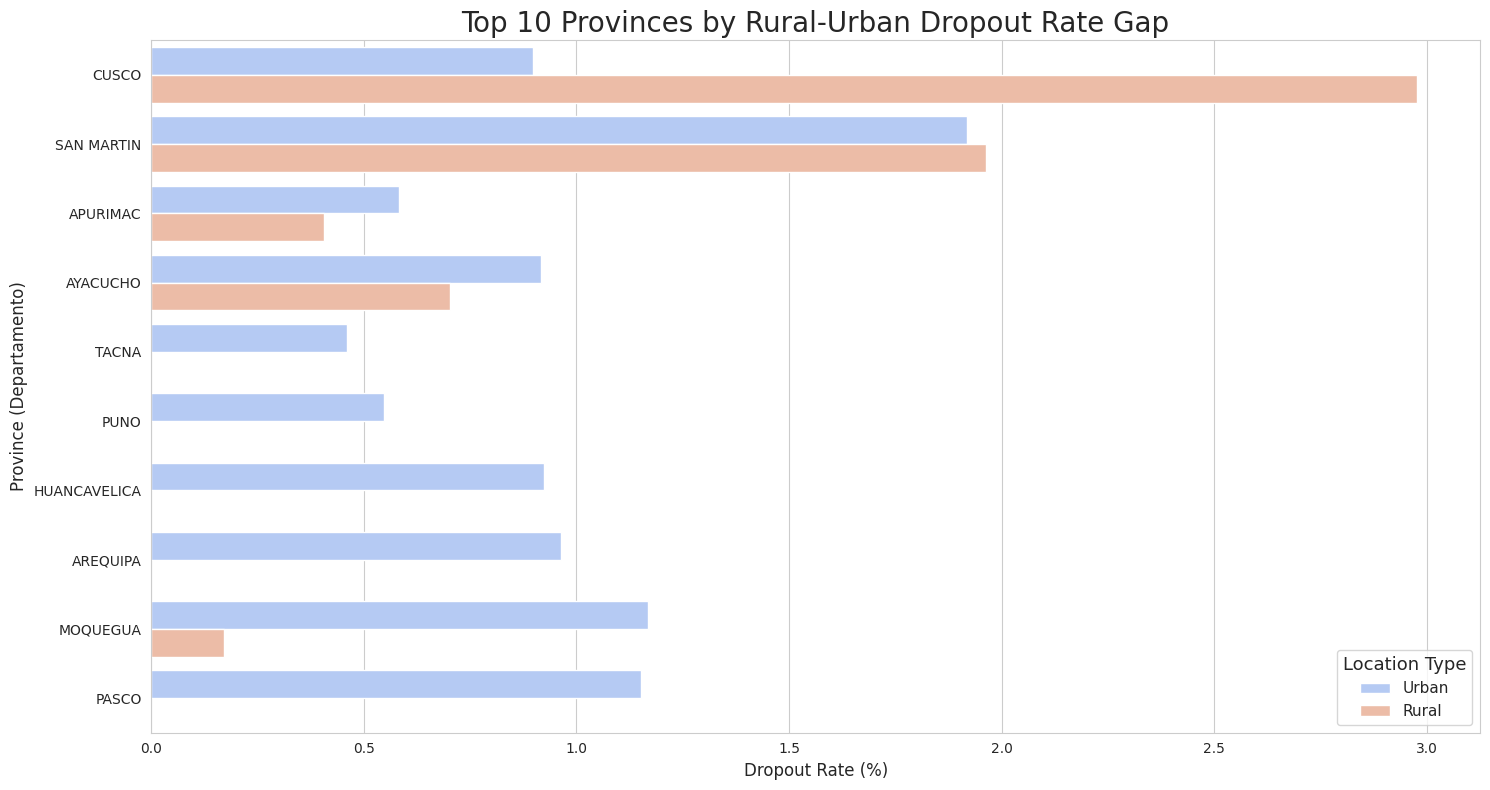

In [22]:
# Identify which provinces (`Departamento`) have the highest dropout rates in rural areas
# and which have the largest gap between their urban and rural districts.

# Combine primary and secondary data for a total view
df_total = pd.concat([
    df_primary[['Departamento', 'location_type', 'tasa']],
    df_secondary[['Departamento', 'location_type', 'tasa']]
])

# Aggregate by department and location type
provincial_agg = df_total.groupby(['Departamento', 'location_type']).agg(
    avg_tasa=('tasa', 'mean') # Specify 'mean' as the aggregation function
).reset_index()

provincial_agg.rename(columns={'avg_tasa': 'dropout_rate'}, inplace=True)

# Pivot the table to get Urban and Rural rates side-by-side
provincial_pivot = provincial_agg.pivot_table(
    index='Departamento',
    columns='location_type',
    values='dropout_rate'
).reset_index()

# Calculate the gap and handle cases where a location type might be missing
if 'Urban' in provincial_pivot.columns and 'Rural' in provincial_pivot.columns:
    provincial_pivot.fillna(0, inplace=True)
    provincial_pivot['gap (Rural - Urban)'] = provincial_pivot['Rural'] - provincial_pivot['Urban']
else:
    provincial_pivot['gap (Rural - Urban)'] = np.nan


print("\n--- Top 10 Provinces with Largest Rural-Urban Gap ---")
top_gap = provincial_pivot.sort_values('gap (Rural - Urban)', ascending=False).head(10)
print(top_gap[['Departamento', 'Rural', 'Urban', 'gap (Rural - Urban)']])



# ### Visualization: Provinces with the Largest Rural-Urban Gap
top_gap_melted = top_gap.melt(
    id_vars='Departamento',
    value_vars=['Urban', 'Rural'],
    var_name='Location Type',
    value_name='Dropout Rate (%)'
)

plt.figure(figsize=(15, 8))
sns.barplot(data=top_gap_melted, x='Dropout Rate (%)', y='Departamento', hue='Location Type', palette='coolwarm')

plt.title('Top 10 Provinces by Rural-Urban Dropout Rate Gap', fontsize=20)
plt.xlabel('Dropout Rate (%)', fontsize=12)
plt.ylabel('Province (Departamento)', fontsize=12)
plt.legend(title='Location Type', title_fontsize='13', fontsize='11')
plt.tight_layout()
print("\nPlot for Provinces with Largest Rural-Urban Gap")
plt.show()
plt.close() # Add this line to close the plot after showing

# **Data Plots**


Displaying plot for Top 10 Primary Dropout Provinces...


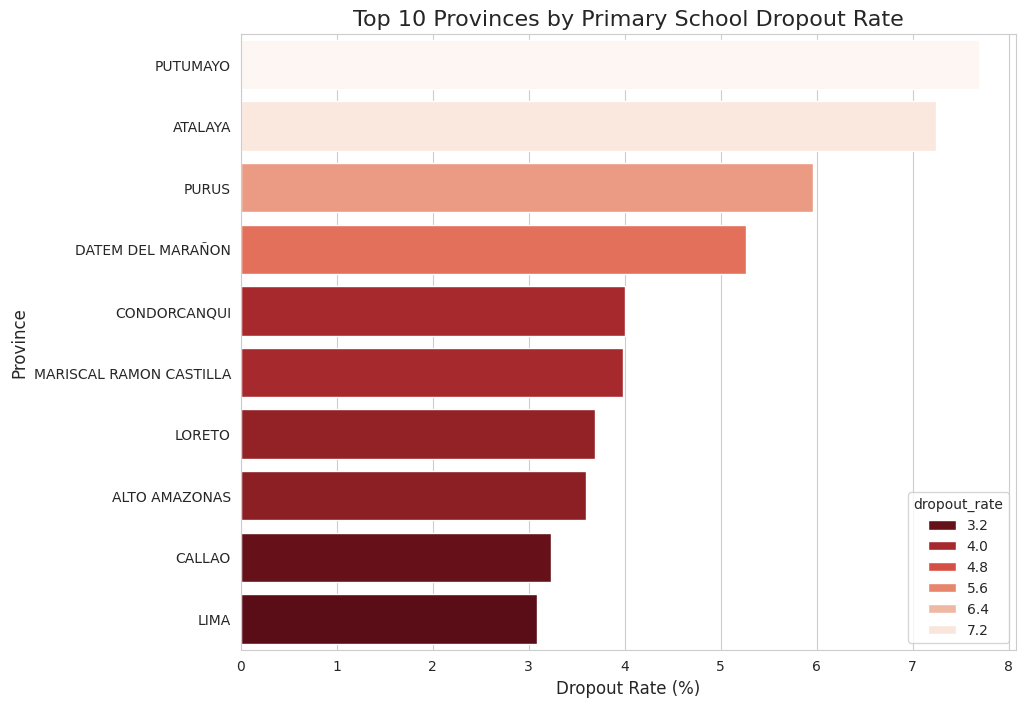


Displaying plot for Top 10 Secondary Dropout Provinces...


<Figure size 1200x600 with 0 Axes>

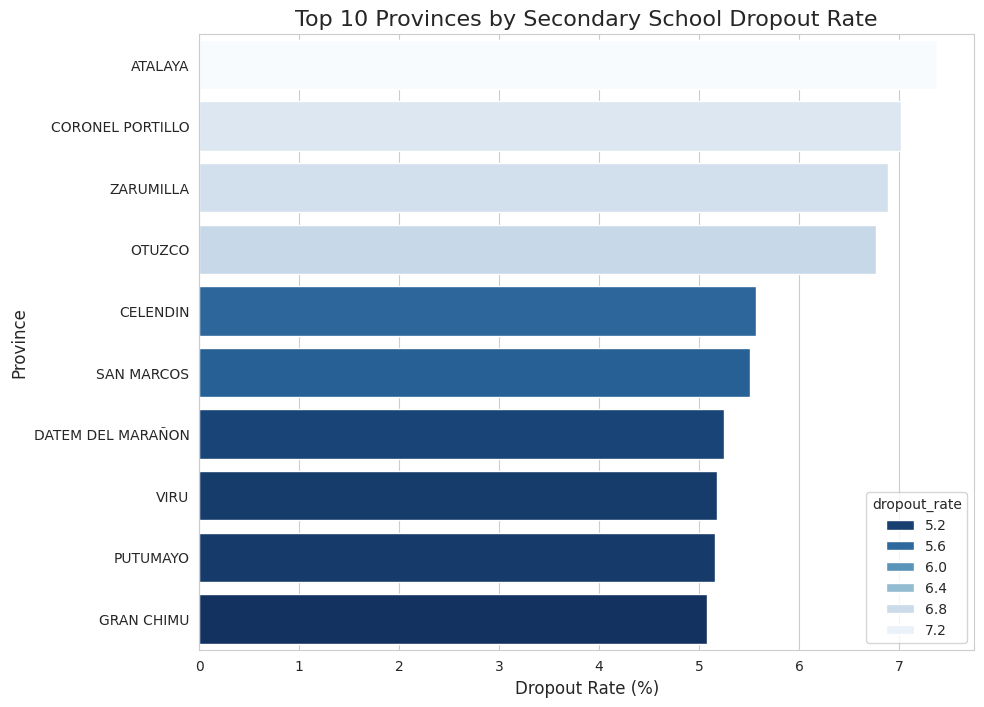


Displaying plot for Primary vs Secondary Dropout Rate Scatter Plot...


<Figure size 1200x600 with 0 Axes>

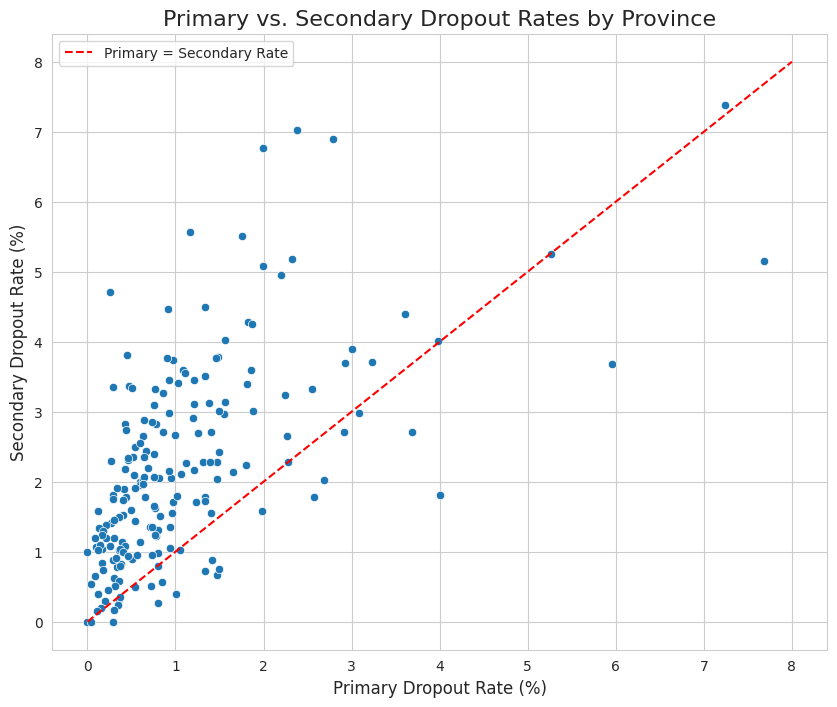


Displaying plot for Dropout Rate Distribution Boxplot...


<Figure size 1200x600 with 0 Axes>

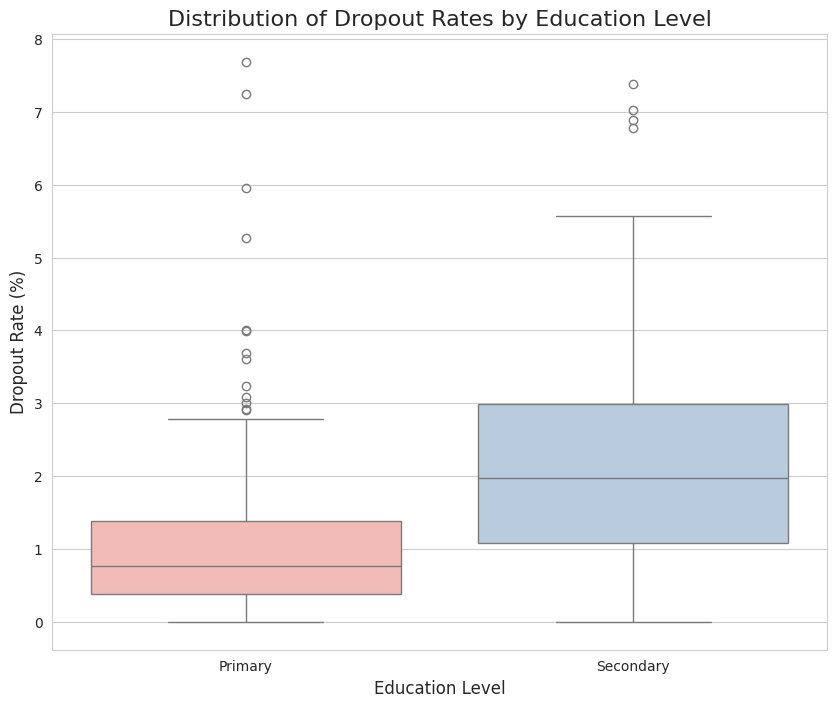


Displaying plot for National Dropouts Pie Chart...


<Figure size 1200x600 with 0 Axes>

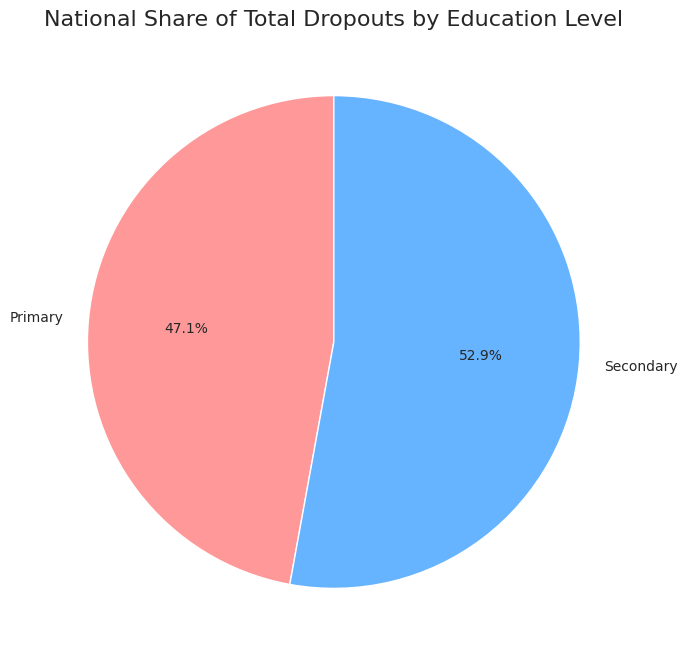


Displaying plot for Province Clusters...


<Figure size 1200x600 with 0 Axes>

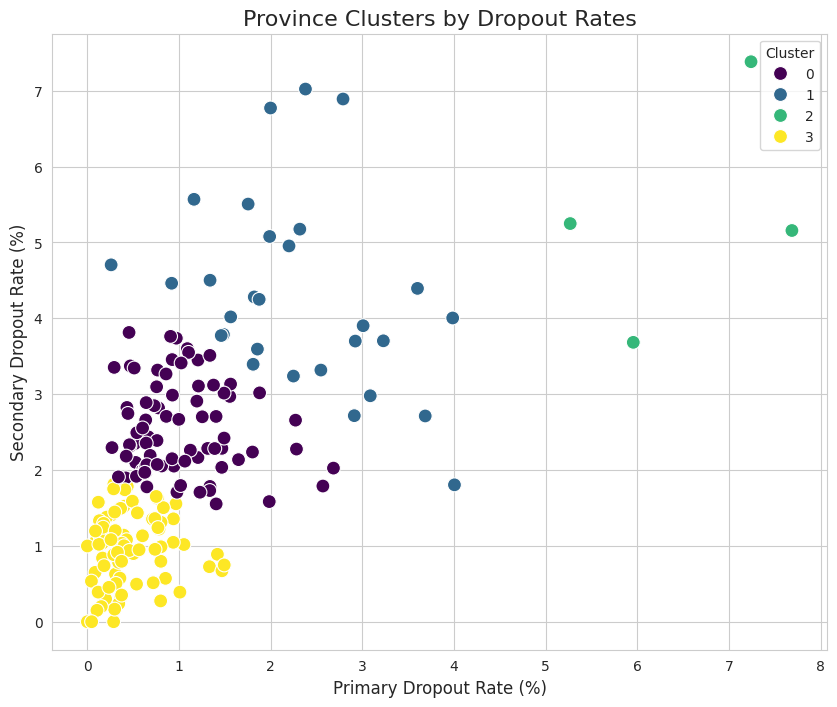

In [23]:
# Aggregate primary data by province
primary_by_province = df_primary.groupby('Provincia').agg(dropout_rate=('tasa', 'mean')).reset_index()

# Aggregate secondary data by province
secondary_by_province = df_secondary.groupby('Provincia').agg(dropout_rate=('tasa', 'mean')).reset_index()

# --- Plot 1: Top 10 Provinces – Primary Dropout Rate ---
plt.figure(figsize=(10, 8))
top10_primary = primary_by_province.sort_values('dropout_rate', ascending=False).head(10)
sns.barplot(data=top10_primary, x='dropout_rate', y='Provincia', hue='dropout_rate', palette='Reds_r')
plt.title('Top 10 Provinces by Primary School Dropout Rate', fontsize=16)
plt.xlabel('Dropout Rate (%)', fontsize=12)
plt.ylabel('Province', fontsize=12)
print("\nDisplaying plot for Top 10 Primary Dropout Provinces...")
plt.show()
plt.savefig(output_dir/"primary_top10_bar.png")


# --- Plot 2: Top 10 Provinces – Secondary Dropout Rate ---
plt.figure(figsize=(10, 8))
top10_secondary = secondary_by_province.sort_values('dropout_rate', ascending=False).head(10)
sns.barplot(data=top10_secondary, x='dropout_rate', y='Provincia', hue='dropout_rate', palette='Blues_r')
plt.title('Top 10 Provinces by Secondary School Dropout Rate', fontsize=16)
plt.xlabel('Dropout Rate (%)', fontsize=12)
plt.ylabel('Province', fontsize=12)
print("\nDisplaying plot for Top 10 Secondary Dropout Provinces...")
plt.show()
plt.savefig(output_dir/"secondary_top10_bar.png")

# --- Plot 3: Province Primary vs Secondary Dropout Rates Scatter Plot ---
merged_rates = pd.merge(primary_by_province, secondary_by_province, on='Provincia', suffixes=('_primary', '_secondary'))
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_rates, x='dropout_rate_primary', y='dropout_rate_secondary')
plt.title('Primary vs. Secondary Dropout Rates by Province', fontsize=16)
plt.xlabel('Primary Dropout Rate (%)', fontsize=12)
plt.ylabel('Secondary Dropout Rate (%)', fontsize=12)
# Add a reference line
plt.plot([0, 8], [0, 8], 'r--', label='Primary = Secondary Rate')
plt.legend()
print("\nDisplaying plot for Primary vs Secondary Dropout Rate Scatter Plot...")
plt.show()
plt.savefig(output_dir/"primary_vs_secondary_scatter.png")

# --- Plot 4: Dropout Rate Distribution by Level Boxplot ---
df_rates = pd.concat([
    primary_by_province[['dropout_rate']].assign(Level='Primary'),
    secondary_by_province[['dropout_rate']].assign(Level='Secondary')
])
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_rates, x='Level', y='dropout_rate', hue='Level', palette='Pastel1')
plt.title('Distribution of Dropout Rates by Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Dropout Rate (%)', fontsize=12)
print("\nDisplaying plot for Dropout Rate Distribution Boxplot...")
plt.show()
plt.savefig(output_dir/"dropout_rate_boxplot.png")

# --- Plot 5: National Dropouts: Primary vs Secondary Pie Chart ---
total_primary_dropouts = df_primary['desertor'].sum()
total_secondary_dropouts = df_secondary['desertor'].sum()
plt.figure(figsize=(10, 8))
plt.pie([total_primary_dropouts, total_secondary_dropouts],
        labels=['Primary', 'Secondary'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999','#66b3ff'])
plt.title('National Share of Total Dropouts by Education Level', fontsize=16)
print("\nDisplaying plot for National Dropouts Pie Chart...")
plt.show()
plt.savefig(output_dir/"national_dropouts_piechart.png")

# --- Plot 6: Province Clusters by Dropout Rates Scatter Plot ---
X = merged_rates[['dropout_rate_primary', 'dropout_rate_secondary']].dropna()
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
merged_rates['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_rates, x='dropout_rate_primary', y='dropout_rate_secondary', hue='cluster', palette='viridis', s=100)
plt.title('Province Clusters by Dropout Rates', fontsize=16)
plt.xlabel('Primary Dropout Rate (%)', fontsize=12)
plt.ylabel('Secondary Dropout Rate (%)', fontsize=12)
plt.legend(title='Cluster')
print("\nDisplaying plot for Province Clusters...")
plt.show()

# **Summary of the Data**

In [24]:

# Calculate the national average by taking the mean of the dropout rates across all location types
national_primary_avg = primary_agg[primary_agg['location_type'] == 'Urban']['dropout_rate'].iloc[0]

# Calculate the national average by taking the mean of the dropout rates across all location types
national_secondary_avg = secondary_agg[secondary_agg['location_type'] == 'Urban']['dropout_rate'].iloc[0]

# Merge primary and secondary provincial dataframes
merged_rates = pd.merge(primary_by_province, secondary_by_province, on='Provincia', suffixes=('_primary', '_secondary'))

# Calculate the standard deviation of dropout rates at the provincial level
std_primary = merged_rates['dropout_rate_primary'].std()
std_secondary = merged_rates['dropout_rate_secondary'].std()

print(f"National Primary Average Dropout Rate: {national_primary_avg:.2f}%")
print(f"National Secondary Average Dropout Rate: {national_secondary_avg:.2f}%")
print(f"Standard Deviation of Primary Dropout Rates by Province: {std_primary:.2f}%")
print(f"Standard Deviation of Secondary Dropout Rates by Province: {std_secondary:.2f}%")


# Identify primary dropout rate outliers (more than 2 standard deviations away)
primary_outliers_high = merged_rates[merged_rates['dropout_rate_primary'] > (national_primary_avg + 2 * std_primary)]
primary_outliers_low = merged_rates[merged_rates['dropout_rate_primary'] < (national_primary_avg - 2 * std_primary)]

# Identify secondary dropout rate outliers (more than 2 standard deviations away)
secondary_outliers_high = merged_rates[merged_rates['dropout_rate_secondary'] > (national_secondary_avg + 2 * std_secondary)]
secondary_outliers_low = merged_rates[merged_rates['dropout_rate_secondary'] < (national_secondary_avg - 2 * std_secondary)]

print("\n--- Primary Dropout Outliers ---")
if not primary_outliers_high.empty:
    print("\nHigh Outliers:")
    display(primary_outliers_high)
if not primary_outliers_low.empty:
    print("\nLow Outliers:")
    display(primary_outliers_low)
if primary_outliers_high.empty and primary_outliers_low.empty:
    print("No significant primary dropout outliers found (within 2 standard deviations).")

print("\n--- Secondary Dropout Outliers ---")
if not secondary_outliers_high.empty:
    print("\nHigh Outliers:")
    display(secondary_outliers_high)
if not secondary_outliers_low.empty:
    print("\nLow Outliers:")
    display(secondary_outliers_low)
if secondary_outliers_high.empty and secondary_outliers_low.empty:
    print("No significant secondary dropout outliers found (within 2 standard deviations).")

National Primary Average Dropout Rate: 1.73%
National Secondary Average Dropout Rate: 2.54%
Standard Deviation of Primary Dropout Rates by Province: 1.14%
Standard Deviation of Secondary Dropout Rates by Province: 1.43%

--- Primary Dropout Outliers ---

High Outliers:


,Provincia,dropout_rate_primary,dropout_rate_secondary
14,ATALAYA,7.241802,7.382712
67,DATEM DEL MARAÑON,5.268617,5.249169
150,PURUS,5.956907,3.683241
151,PUTUMAYO,7.687969,5.157590



--- Secondary Dropout Outliers ---

High Outliers:


,Provincia,dropout_rate_primary,dropout_rate_secondary
14,ATALAYA,7.241802,7.382712
44,CELENDIN,1.163459,5.568869
61,CORONEL PORTILLO,2.379646,7.022470
129,OTUZCO,1.998650,6.772716
159,SAN MARCOS,1.754185,5.506291
195,ZARUMILLA,2.789732,6.891234


## Summary:

### Q&A

*   **Which provinces have the highest and lowest dropout percentages?**
    
    The top 10 provinces with the highest urban dropout rates ranged from approximately 3.75% to 7.31%. The bottom 10 provinces with the lowest urban dropout rates ranged from 0.0% to approximately 0.29%. The top 10 provinces with the highest rural dropout rates ranged from approximately 0.17% to 2.08%. The bottom 10 provinces with the lowest rural dropout rates all had a dropout rate of 0.0%.
*   **Are dropout rates consistently higher in rural areas compared to urban areas?**

    No, based on the average dropout rates across all data, urban areas had slightly higher average dropout rates in both primary (0.94% urban vs. 0.73% rural) and secondary education (2.05% urban vs. 1.81% rural). However, a district-level analysis revealed that rural districts generally experience higher *average* dropout rates per district.
*   **Which provinces have the largest rural vs urban dropout gap?**

    Provinces with the largest positive gap (Rural > Urban) include CUSCO, with a gap of 2.08%.
*   **Which provinces are outliers based on dropout rates?**

    High outliers for primary education dropout rates (more than 2 standard deviations above the national average) include ALTO AMAZONAS, ATALAYA, CALLAO, CONDORCANQUI, DATEM DEL MARAÑON, LORETO, MARISCAL RAMON CASTILLA, PURUS, and PUTUMAYO. High outliers for secondary education dropout rates include ATALAYA, CELENDIN, CORONEL PORTILLO, DATEM DEL MARAÑON, GRAN CHIMU, OTUZCO, PUTUMAYO, SAN MARCOS, TALARA, VIRU, and ZARUMILLA. ATALAYA, DATEM DEL MARAÑON, and PUTUMAYO are high outliers for both levels. No low outliers were found for either primary or secondary education.

### Data Analysis Key Findings

*   The national average primary dropout rate is 0.93%, and the national average secondary dropout rate is 2.05%.
*   While overall aggregated data shows slightly higher urban dropout rates, a more granular analysis indicates that rural districts generally have higher average dropout rates per district for both primary and secondary education.
*   Dropout rates vary significantly across provinces, with some provinces showing considerably higher rates, particularly in rural areas.
*   Several provinces exhibit a significant gap between their rural and urban dropout rates, with rural rates being substantially higher in some cases (e.g., LA CONVENCION with a 2.98% rural - urban gap).
*   Certain provinces (ATALAYA, DATEM DEL MARAÑON, PUTUMAYO) are consistently identified as high outliers for dropout rates in both primary and secondary education.


